In [1]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, BertTokenizerFast, get_linear_schedule_with_warmup
import numpy as np
import random
from tqdm import tqdm

In [2]:
# Fixing randomness to get reproducible results
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [3]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


## Load dataset

In [4]:
from src.utils import load_data

DATA_PATH = "data/train_extended.json"
df = load_data(DATA_PATH)

# Report the number of sentences.
print('Number of sentences: {:,}\n'.format(df.shape[0]))

print('Distribution of classes:\n', df["label"].value_counts())

Number of sentences: 336

Distribution of classes:
 label
Politics         28
Health           28
Finance          28
Travel           28
Food             28
Education        28
Environment      28
Fashion          28
Science          28
Sports           28
Technology       28
Entertainment    28
Name: count, dtype: int64


In [5]:
# Transform labels in numbers
unique_labels = df["label"].unique()
label_dict = {label: id for id, label in enumerate(unique_labels)}
reverse_label_dict = {id: label for label, id in label_dict.items()}

# Get the lists of sentences and their labels.
sentences = df['text'].values
labels = df['label'].apply(lambda x: label_dict[x]).values
labels

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  8,  8

## Tokenise sentences

In [6]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [7]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  The mayor announced a new initiative to improve public transportation.
Tokenized:  ['the', 'mayor', 'announced', 'a', 'new', 'initiative', 'to', 'improve', 'public', 'transportation', '.']
Token IDs:  [1996, 3664, 2623, 1037, 2047, 6349, 2000, 5335, 2270, 5193, 1012]


In [8]:
print('Max sentence length: ', max([len(sen) for sen in tokenizer(sentences.tolist())['input_ids']]))

Max sentence length:  23


We choose a maximum sentence length of 32

In [9]:
MAX_LEN = 32

In [13]:
#   (1) Tokenize the sentence.
#   (2) Prepend the `[CLS]` token to the start.
#   (3) Append the `[SEP]` token to the end.
#   (4) Map tokens to their IDs.
#   (5) Truncate or do padding to max_length if needed
#   (6) Create the attention mask needed for the model
tokenized = tokenizer(sentences.tolist(), padding="max_length", max_length=MAX_LEN, truncation=True)
input_ids = tokenized['input_ids']
attention_masks = tokenized['attention_mask']

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])
print('Attention mask:', attention_masks[0])

Original:  The mayor announced a new initiative to improve public transportation.
Token IDs: [101, 1996, 3664, 2623, 1037, 2047, 6349, 2000, 5335, 2270, 5193, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Attention mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [14]:
# Use train_validation_split to split our data into train and validation sets for training
# We use stratify to keep a good distribution in our train and validation sets
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, labels, test_size=0.33, stratify=labels
)

# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(
    attention_masks, labels, test_size=0.33, stratify=labels
)

## Convert to PyTorch data types

In [15]:
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [16]:
# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

BATCH_SIZE = 16

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=BATCH_SIZE)

## Train the model

In [18]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = len(label_dict), # The number of output labels 
    output_attentions = False, # Whether the model returns attention weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# comment this to do fine-tuning, otherwise we do transfer learning
# for name, param in model.named_parameters():
# 	if 'classifier' not in name: # classifier layer
# 		param.requires_grad = False

# Tell pytorch to run this model on the GPU.
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [28]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [29]:
optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, we set it at 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [30]:
# Number of training epochs (authors recommend between 2 and 4)
EPOCHS = 50

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * EPOCHS

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [31]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [32]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [20]:
# # Store the average loss after each epoch so we can plot them.
# loss_values = []

# # For each epoch...
# for epoch_i in range(0, EPOCHS):
    
#     # ========================================
#     #               Training
#     # ========================================
    
#     # Perform one full pass over the training set.

#     print("")
#     print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, EPOCHS))
#     print('Training...')

#     # Measure how long the training epoch takes.
#     t0 = time.time()

#     # Reset the total loss for this epoch.
#     total_loss = 0

#     # Put the model into training mode.
#     model.train()

#     # For each batch of training data...
#     for step, batch in enumerate(train_dataloader):

#         # Progress update every 40 batches.
#         if step % 40 == 0 and not step == 0:
#             # Calculate elapsed time in minutes.
#             elapsed = format_time(time.time() - t0)
            
#             # Report progress.
#             print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

#         # Unpack this training batch from our dataloader. 
#         #
#         # As we unpack the batch, we'll also copy each tensor to the GPU using the 
#         # `to` method.
#         #
#         # `batch` contains three pytorch tensors:
#         #   [0]: input ids 
#         #   [1]: attention masks
#         #   [2]: labels 
#         b_input_ids = batch[0].to(device)
#         b_input_mask = batch[1].to(device)
#         b_labels = batch[2].to(device)

#         # Always clear any previously calculated gradients before performing a
#         # backward pass.
#         model.zero_grad()        

#         # Perform a forward pass (evaluate the model on this training batch).
#         outputs = model(b_input_ids, 
#                     token_type_ids=None, 
#                     attention_mask=b_input_mask, 
#                     labels=b_labels)
        
#         # The call to `model` always returns a tuple, so we need to pull the 
#         # loss value out of the tuple.
#         loss = outputs[0]

#         # Accumulate the training loss over all of the batches so that we can
#         # calculate the average loss at the end. `loss` is a Tensor containing a
#         # single value; the `.item()` function just returns the Python value 
#         # from the tensor.
#         total_loss += loss.item()

#         # Perform a backward pass to calculate the gradients.
#         loss.backward()

#         # Clip the norm of the gradients to 1.0.
#         # This is to help prevent the "exploding gradients" problem.
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

#         # Update parameters and take a step using the computed gradient.
#         optimizer.step()

#         # Update the learning rate.
#         scheduler.step()

#     # Calculate the average loss over the training data.
#     avg_train_loss = total_loss / len(train_dataloader)            
    
#     # Store the loss value for plotting the learning curve.
#     loss_values.append(avg_train_loss)

#     print("")
#     print("  Average training loss: {0:.2f}".format(avg_train_loss))
#     print("  Training epoch took: {:}".format(format_time(time.time() - t0)))
        
#     # ========================================
#     #                 Validation
#     # ========================================
#     # After the completion of each training epoch, measure our performance on
#     # our validation set.

#     print("")
#     print("Running validation...")

#     t0 = time.time()

#     # Put the model in evaluation mode--the dropout layers behave differently
#     # during evaluation.
#     model.eval()

#     # Tracking variables 
#     eval_loss, eval_accuracy = 0, 0
#     nb_eval_steps, nb_eval_examples = 0, 0

#     # Evaluate data for one epoch
#     for batch in validation_dataloader:
        
#         # Add batch to GPU
#         batch = tuple(t.to(device) for t in batch)
        
#         # Unpack the inputs from our dataloader
#         b_input_ids, b_input_mask, b_labels = batch
        
#         # Telling the model not to compute or store gradients, saving memory and
#         # speeding up validation
#         with torch.no_grad():        

#             # Forward pass, calculate logit predictions.
#             # This will return the logits rather than the loss because we have
#             # not provided labels.
#             outputs = model(b_input_ids, 
#                             token_type_ids=None, 
#                             attention_mask=b_input_mask)
        
#         # Get the "logits" output by the model. The "logits" are the output
#         # values prior to applying an activation function like the softmax.
#         logits = outputs[0]

#         # Move logits and labels to CPU
#         logits = logits.detach().cpu().numpy()
#         label_ids = b_labels.to('cpu').numpy()
        
#         # Calculate the accuracy for this batch of validation sentences.
#         tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
#         # Accumulate the total accuracy.
#         eval_accuracy += tmp_eval_accuracy

#         # Track the number of batches
#         nb_eval_steps += 1

#     # Report the final accuracy for this validation run.
#     print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
#     print("  Validation took: {:}".format(format_time(time.time() - t0)))

# print("")
# print("Training complete!")

In [21]:
# import matplotlib.pyplot as plt

# # Increase the plot size and font size.
# plt.rcParams["figure.figsize"] = (12,6)

# # Plot the learning curve.
# plt.plot(loss_values, 'b-o')

# # Label the plot.
# plt.title("Training loss")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")

# plt.show()

# Perform training on the whole dataset

In [33]:
train_inputs = torch.tensor(input_ids)
train_labels = torch.tensor(labels)
train_masks = torch.tensor(attention_masks)

BATCH_SIZE = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = len(label_dict), # The number of output labels 
    output_attentions = False, # Whether the model returns attention weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# comment this to do fine-tuning, otherwise we do transfer learning
# for name, param in model.named_parameters():
# 	if 'classifier' not in name: # classifier layer
# 		param.requires_grad = False

model.to(device)

optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, we set it at 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


# Number of training epochs (authors recommend between 2 and 4)
EPOCHS = 30

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * EPOCHS

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, EPOCHS):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, EPOCHS))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode.
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass.
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))


======== Epoch 1 / 30 ========
Training...

  Average training loss: 2.42
  Training epoch took: 0:00:12

======== Epoch 2 / 30 ========
Training...

  Average training loss: 2.09
  Training epoch took: 0:00:12

======== Epoch 3 / 30 ========
Training...

  Average training loss: 1.74
  Training epoch took: 0:00:12

======== Epoch 4 / 30 ========
Training...

  Average training loss: 1.38
  Training epoch took: 0:00:13

======== Epoch 5 / 30 ========
Training...

  Average training loss: 1.01
  Training epoch took: 0:00:13

======== Epoch 6 / 30 ========
Training...

  Average training loss: 0.70
  Training epoch took: 0:00:13

======== Epoch 7 / 30 ========
Training...

  Average training loss: 0.46
  Training epoch took: 0:00:13

======== Epoch 8 / 30 ========
Training...

  Average training loss: 0.28
  Training epoch took: 0:00:13

======== Epoch 9 / 30 ========
Training...

  Average training loss: 0.18
  Training epoch took: 0:00:13

======== Epoch 10 / 30 ========
Training...



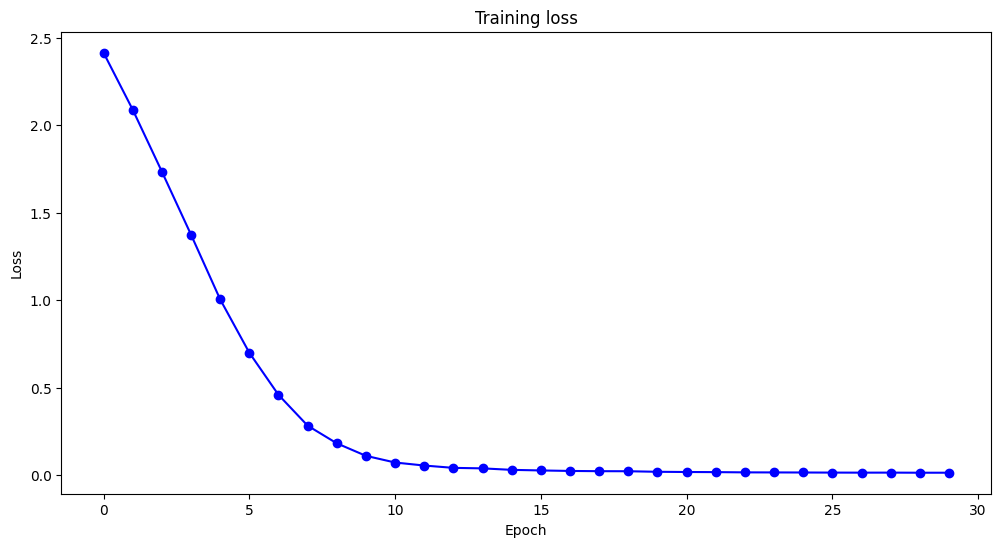

In [ ]:
import matplotlib.pyplot as plt

# Increase the plot size and font size.
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [ ]:
test_df = load_data("data/test_shuffle.txt")

test_sentences = test_df['text'].values

test_tokenized = tokenizer(test_sentences.tolist(), padding="max_length", max_length=MAX_LEN, truncation=True)
test_input_ids = test_tokenized['input_ids']
test_attention_masks = test_tokenized['attention_mask']

test_inputs = torch.tensor(test_input_ids)
test_masks = torch.tensor(test_attention_masks)

# Create the DataLoader for our test set.
test_data = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE)

In [ ]:
print("Running on test data...")

t0 = time.time()

# Put the model in evaluation mode
model.eval()

preds = np.array([])

for batch in tqdm(test_dataloader):
    
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask = batch
    
    # Telling the model not to compute or store gradients, saving memory and
    # speeding up validation
    with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        # This will return the logits rather than the loss because we have
        # not provided labels.
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    
    # Get the "logits" output by the model. The "logits" are the output
    # values prior to applying an activation function like the softmax.
    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    
    preds = np.concatenate([preds, np.argmax(logits, axis=1)])

Running on test data...


100%|██████████| 72/72 [00:10<00:00,  6.73it/s]


In [ ]:
preds.shape

(1140,)

In [ ]:
pred_df = pd.DataFrame(preds, columns=["label"], dtype=int)
pred_df["label"] = pred_df["label"].apply(lambda x: reverse_label_dict[x])
pred_df.head()

,label
0,Finance
1,Environment
2,Science
3,Finance
4,Environment


In [29]:
pred_df.to_csv("data/submission.csv", index=True, header=True, index_label="ID")